# Machine Learning for Wind Power Forecasting

This notebook implements multiple models for wind power forecasting. The first explores a one-step model that predicts the wind power

In [68]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from albatross.analysis import plot_windrose, boxplot
from sklearn.ensemble import RandomForestRegressor
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

/Users/cam/workspace/osu/projects/REStats/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmap = mpl.colormaps['tab10']

## Data

The data consists of two years (2019-2020) of Wind Turbine data from the Kelmarsh Wind Farm in the UK.

_TODO: Use full farm data in analysis (currently using one turbine)._ 

Plumley, Charlie. Kelmarsh Wind Farm Data. Zenodo, 1 Feb. 2022. Zenodo, https://doi.org/10.5281/zenodo.5841834.


In [3]:
# DATA_DIRS = ['../data/Kelmarsh_SCADA_2019/', '../data/Kelmarsh/SCADA_2020']

# FNAMES = [
#     "Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv",
    # "Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv",
    # "Turbine_Data_Kelmarsh_3_2020-01-01_-_2021-01-01_230.csv",
    # "Turbine_Data_Kelmarsh_4_2020-01-01_-_2021-01-01_231.csv",
    # "Turbine_Data_Kelmarsh_5_2020-01-01_-_2021-01-01_232.csv",
    # "Turbine_Data_Kelmarsh_6_2020-01-01_-_2021-01-01_233.csv",
# ]

# turbines = []

# for i, _ in enumerate(FNAMES):
#     fname = DATA_DIR + FNAMES[i]
#     print(f"Loading data: {FNAMES[i]}")
#     wt = pd.read_csv(fname, header=9)
#     turbines.append(wt)

wt_2019 = pd.read_csv("../data/Kelmarsh_SCADA_2019/Turbine_Data_Kelmarsh_1_2019-01-01_-_2020-01-01_228.csv", header=9)
wt_2020 = pd.read_csv("../data/Kelmarsh_SCADA_2020/Turbine_Data_Kelmarsh_1_2020-01-01_-_2021-01-01_228.csv", header=9)

wt_raw = pd.concat([wt_2019, wt_2020])

In [4]:
wt_raw.columns[wt_raw.columns.str.contains("power")]

Index(['Potential power default PC (kW)', 'Potential power learned PC (kW)',
       'Potential power reference turbines (kW)',
       'Cascading potential power (kW)',
       'Cascading potential power for performance (kW)',
       'Potential power met mast anemometer (kW)',
       'Potential power primary reference turbines (kW)',
       'Potential power secondary reference turbines (kW)',
       'Potential power estimated (kW)', 'Potential power MPC (kW)',
       'Potential power met mast anemometer MPC (kW)', 'Reactive power (kvar)',
       'Reactive power, Max (kvar)', 'Reactive power, Min (kvar)',
       'Reactive power, Standard deviation (kvar)', 'Apparent power (kVA)',
       'Apparent power, Max (kVA)', 'Apparent power, Min (kVA)',
       'Apparent power, StdDev (kVA)'],
      dtype='object')

In [5]:
wt = wt_raw.loc[:, ["# Date and time", "Power (kW)", "Wind direction (°)", "Wind speed (m/s)"]]
wt = wt.rename(columns={"# Date and time": "Date", "Power (kW)": "Power", "Wind direction (°)": "Wind direction", "Wind speed (m/s)": "Wind speed"})
wt["Date"] = pd.to_datetime(wt["Date"].astype("datetime64"))
wt = wt.set_index("Date")
wt = wt.asfreq("10min")

wt["Power"].bfill(inplace=True)
wt["Wind direction"].bfill(inplace=True)
wt["Wind speed"].bfill(inplace=True)
# wt["Power"] = wt["Power"].transform(lambda p: max(p, 0))
wt = wt.sort_index()

wt.head()

,Power,Wind direction,Wind speed
Date,,,
2019-01-01 00:00:00,191.814896,284.644043,4.454060
2019-01-01 00:10:00,189.524963,288.776154,4.331436
2019-01-01 00:20:00,381.144653,292.093292,5.447210
2019-01-01 00:30:00,422.717590,294.645264,5.472900
2019-01-01 00:40:00,307.518646,299.022400,5.601278


In [6]:
(wt.index == pd.date_range(start=wt.index.min(),
                             end=wt.index.max(),
                             freq=wt.index.freq)).all()

True

In [7]:
wt.describe()

,Power,Wind direction,Wind speed
count,105264.000000,105264.000000,105264.000000
mean,658.230309,200.768777,6.298800
std,645.270553,90.442918,2.883361
min,-17.846463,0.007310,0.134232
25%,125.766387,143.144123,4.226321
50%,431.540100,218.771682,6.025231
75%,1035.737753,261.830924,7.927109
max,2081.028912,359.996088,22.419562


In [133]:
len(wt[wt["Power"].isnull()]) == 0

True

In [9]:
speed = wt.loc[:, "Wind speed"]
direction = wt.loc[:, "Wind direction"]
active_power = wt.loc[:, "Power"]

The wind speed distribution represents a typical right-skewed distribution, where we see the highest counts around 5-6 m/s

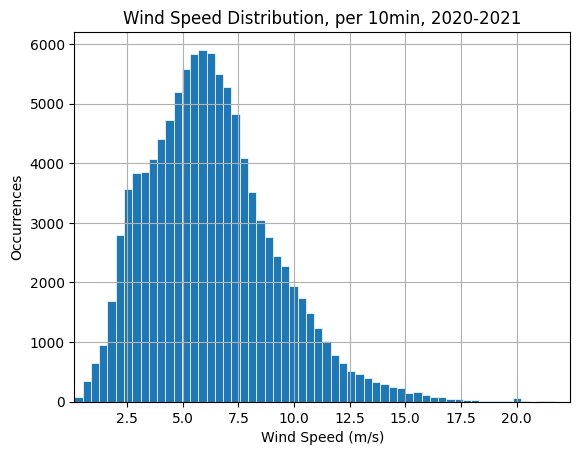

In [10]:
fig, ax = plt.subplots()

ax.set_title("Wind Speed Distribution, per 10min, 2020-2021")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Occurrences")
ax.set_xmargin(0)
ax.hist(speed, 60, linewidth=0.5, edgecolor="white")
ax.grid(True)

A wind rose is a useful visualization that simultaneously characterizes wind speed and wind direction. The magnitude of a spoke represents the percentage of time in that direction. In this one we see that the predominant wind direction is SW.

<WindroseAxes:>

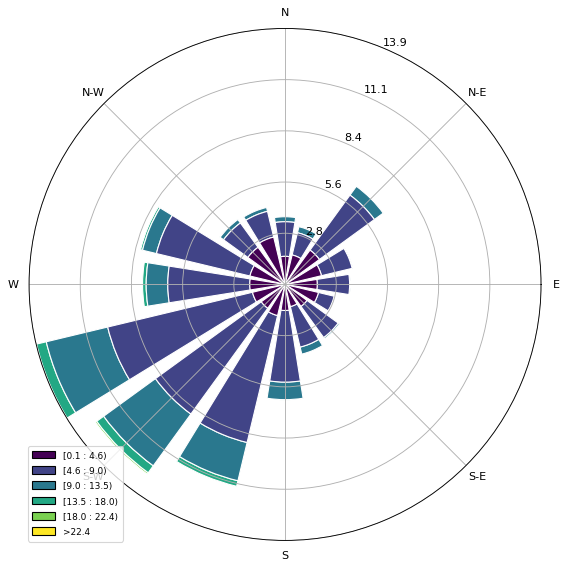

In [11]:
plot_windrose(wt, speed="Wind speed", direction="Wind direction")

We can also look at wind speed vs power output. We see that there is a strong correlation between the two, which is expected. There's an exception here in the middle of the day, where the power drops to zero. It looks like the turbine cut-in speed is around 2 m/s, meaning that it will shut off below that wind speed.

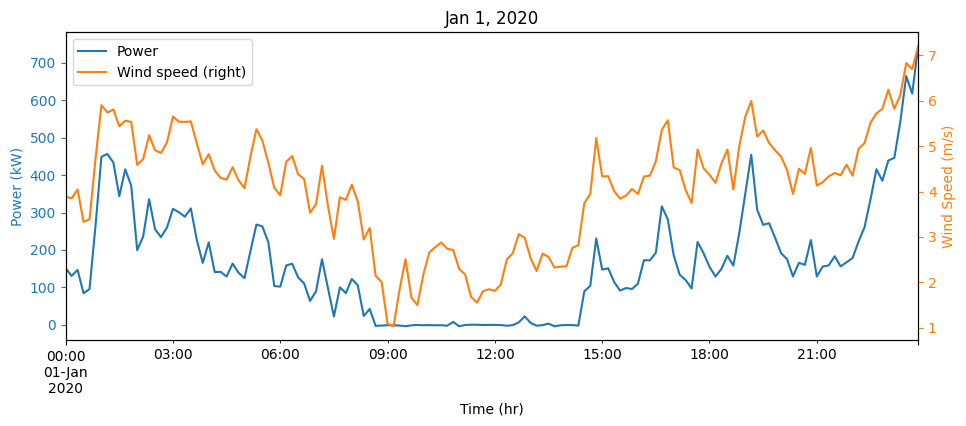

In [134]:
wt_1day = wt.loc[(wt.index >= "2020-01-01") & (wt.index < "2020-01-02")]

fig, ax1 = plt.subplots(figsize=(11, 4))

wt_1day[["Power", "Wind speed"]].plot(secondary_y="Wind speed", ax=ax1)

ax1.set_title("Jan 1, 2020")
ax1.set_ylabel("Power (kW)")
ax1.set_xmargin(0)
ax1.set_xlabel("Time (hr)")
ax1.tick_params(axis='y', colors=cmap.colors[0])
ax1.yaxis.label.set_color(cmap.colors[0])
ax1.right_ax.set_ylabel("Wind Speed (m/s)")
ax1.right_ax.yaxis.label.set_color(cmap.colors[1])
ax1.right_ax.tick_params(axis='y', colors=cmap.colors[1])

If we plot all of the observations of wind speed vs power, we get a representation of the turbine's power curve. As we saw before, it appears that the cut-in speed is around 2 m/s, and the rated power is around 2000 kW, or 2 MW. The turbine controls will prevent it from attempting to produce beyond that point, so the curve levels off at that power. Finally, we see that the cut-out speed is around 20 m/s, where the turbine will shut down to prevent damage from high winds.

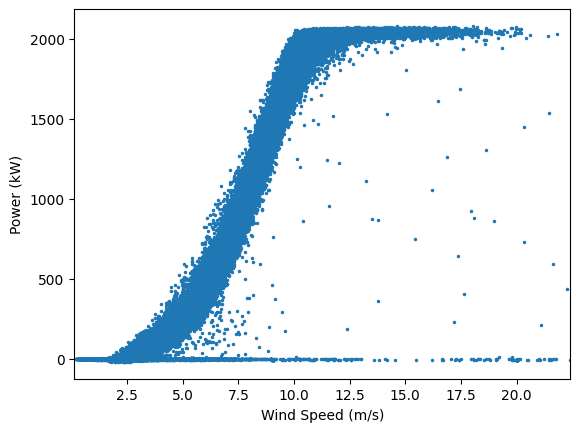

In [13]:
ax = plt.subplot()
ax.plot(speed, active_power, "o", markersize=1.5)
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_xmargin(0)

In [135]:
# wt_yr = wt[:, ["Direction", "Wind speed", "Power"]]
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_trisurf(direction, speed, active_power)

This information is useful, but in order to form a forecasting model, we need to determine a feature set that incorporates an intuition about the past so that we can predict the future. One way to look at this is through autocorrelation: how does past power correlate with current power? We can explore this by calculating the correlation coefficients of current power with its past values, also called "lags". We see from the plot that current power is highly correlated with past power, up to a certain point. With this knowledge, we can attempt to build a model that uses these lags themselves as features!

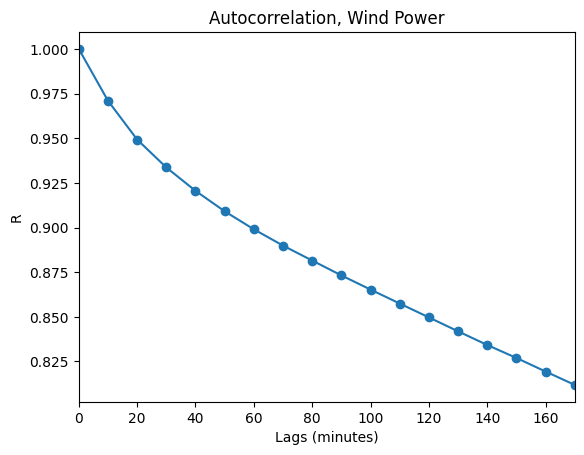

In [110]:
period = wt.index.to_series().asfreq("10T")[18:]

LAG = 18

X = np.zeros((len(period), LAG))
y = np.zeros(len(period))

current = LAG

for i, row in enumerate(X):
    X[i, :LAG] = data[current-LAG:current]
    y[i] = data[current]
    current += 1

columns = [f"p_{18-i}0" for i in range(LAG)]

X = pd.DataFrame(X, index=period, columns=columns)
y = pd.Series(y, index=period)

X.head(2)


ax = plt.subplot()

results = []

for i in range(LAG):
    corr = np.corrcoef(X[f"p_180"], X[f"p_{18-i}0"])
    results.append(corr[0, 1])
    
results

x = np.arange(0, 180, 10)
ax.scatter(x, results)
ax.plot(x, results)
ax.set_xlabel("Lags (minutes)")
ax.set_ylabel("R")
ax.set_title("Autocorrelation, Wind Power")
ax.set_xmargin(0)

## First approach: single step model

This model trains a Random Forest regressor using lags as features. 

Building the feature matrix consists of the following steps:
1. Create a new timeseries with frequency of half an hour, starting at 1:00 (the first half hour must be used for lag data)
2. For each half hour, set lags as defined by the `LAG` variable, which represents the number of 10min increments to include as features
3. For each half hour, set the output `y` as the power output at the "current" time step

The result is a feature matrix that, for each half hour, represents 30min of power starting one hour prior.

In [112]:
data = wt["Power"]

data.head(13)

Date
2019-01-01 00:00:00    191.814896
2019-01-01 00:10:00    189.524963
2019-01-01 00:20:00    381.144653
2019-01-01 00:30:00    422.717590
2019-01-01 00:40:00    307.518646
2019-01-01 00:50:00    100.532738
2019-01-01 01:00:00     51.613712
2019-01-01 01:10:00    152.640259
2019-01-01 01:20:00    188.583817
2019-01-01 01:30:00    154.423843
2019-01-01 01:40:00    262.382996
2019-01-01 01:50:00    347.363495
2019-01-01 02:00:00    394.709747
Freq: 10T, Name: Power, dtype: float64

In [113]:
period = wt.index.to_series().asfreq("30T")[2:]

LAG = 3

X = np.zeros((len(period), LAG))
y = np.zeros(len(period))

current = 6

for i, row in enumerate(X):
    X[i, :LAG] = data[current-6:current-LAG]
    y[i] = data[current]
    current += 3

columns = [f"p_{6-i}0" for i in range(LAG)]

X = pd.DataFrame(X, index=period, columns=columns)
y = pd.Series(y, index=period)

X.head(2)

,p_60,p_50,p_40
Date,,,
2019-01-01 01:00:00,191.814896,189.524963,381.144653
2019-01-01 01:30:00,422.717590,307.518646,100.532738


In [114]:
y

Date
2019-01-01 01:00:00     51.613712
2019-01-01 01:30:00    154.423843
2019-01-01 02:00:00    394.709747
2019-01-01 02:30:00    579.502258
2019-01-01 03:00:00    468.327240
                          ...    
2020-12-31 21:30:00     -1.108080
2020-12-31 22:00:00     -1.390301
2020-12-31 22:30:00     -1.022186
2020-12-31 23:00:00     -1.348688
2020-12-31 23:30:00     -2.240700
Length: 35086, dtype: float64

In [115]:
np.array_equal(X.iloc[0, :], data[:LAG])

True

In [116]:
X_train = X[X.index < "2020-01-01"]
X_test = X[(X.index >= "2020-01-01")]
y_train = y[y.index < "2020-01-01"]
y_test = y[(X.index >= "2020-01-01")]

In [117]:
X_train

,p_60,p_50,p_40
Date,,,
2019-01-01 01:00:00,191.814896,189.524963,381.144653
2019-01-01 01:30:00,422.717590,307.518646,100.532738
2019-01-01 02:00:00,51.613712,152.640259,188.583817
2019-01-01 02:30:00,154.423843,262.382996,347.363495
2019-01-01 03:00:00,394.709747,446.346191,442.942749
...,...,...,...
2019-12-31 21:30:00,455.926382,228.359885,255.842170
2019-12-31 22:00:00,239.837794,166.988038,120.766393
2019-12-31 22:30:00,103.285203,130.113327,152.384157


In [118]:
X_test

,p_60,p_50,p_40
Date,,,
2020-01-01 00:00:00,129.151435,121.942842,171.363560
2020-01-01 00:30:00,232.957892,282.135746,193.669499
2020-01-01 01:00:00,150.984141,130.414782,146.401656
2020-01-01 01:30:00,84.296224,94.994105,262.992229
2020-01-01 02:00:00,449.115810,456.427864,433.714243
...,...,...,...
2020-12-31 21:30:00,-1.142224,-2.314323,-1.609036
2020-12-31 22:00:00,-1.106311,-1.904062,-1.033923
2020-12-31 22:30:00,-1.108080,-2.139335,-1.055263


In [119]:
# X_test.loc["2020-02-29"] # it's a leap year :^D

Train a Random Forest regressor using a training set consisting of 2019 data.

In [120]:
rf = RandomForestRegressor(n_estimators=500, oob_score=True)
rf

RandomForestRegressor(n_estimators=500, oob_score=True)

Calculate an out-of-bag (OOB) estimate, coefficient of determination ($R^2$), root mean squared error (RMSE) and mean absolute error (MAE).

In [121]:
rf.fit(X_train, y_train)

rf.oob_score_

0.8194285659450845

In [122]:
rf.score(X_test, y_test)

0.8553051128673602

In [123]:
predictions = pd.Series(rf.predict(X_test), index=X_test.index)
predictions

Date
2020-01-01 00:00:00    187.492644
2020-01-01 00:30:00    211.782040
2020-01-01 01:00:00    181.234106
2020-01-01 01:30:00    244.325422
2020-01-01 02:00:00    454.978002
                          ...    
2020-12-31 21:30:00     17.875575
2020-12-31 22:00:00      2.967730
2020-12-31 22:30:00     42.380938
2020-12-31 23:00:00     75.081883
2020-12-31 23:30:00     43.496421
Length: 17568, dtype: float64

In [124]:
# RMSE
mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)

258.99156773686457

In [125]:
# MAE
np.mean(abs(y_test-predictions))

172.7240947998004

Plot Dec 2019 - Feb 2020 using train, test, and prediction sets.

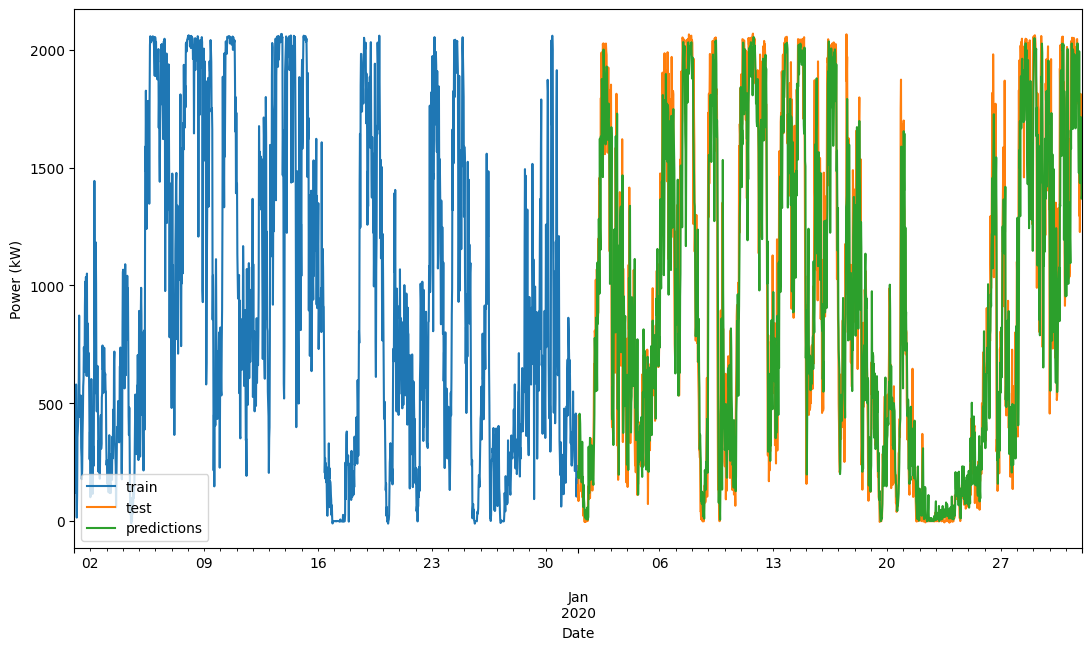

In [127]:
fig, ax = plt.subplots(figsize=(13, 7))
y_train[(y_train.index > "12-01-2019") & (y_train.index <= "12-01-2020")].plot(ax=ax, label="train")
y_test[y_test.index < "02-01-2020"].plot(ax=ax, label="test")
predictions[predictions.index < "02-01-2020"].plot(ax=ax, label="predictions")
ax.set_ylabel("Power (kW)")
ax.legend();

Feature importance for lags increases as they approach the current time. The most important lag, `p_50`, shows that the 10min preceding 

In [129]:
rf.feature_importances_

array([0.06176052, 0.05957936, 0.87866012])

In [130]:
feature_sort = np.argsort(rf.feature_importances_)
X.columns[feature_sort]

Index(['p_50', 'p_60', 'p_40'], dtype='object')

## Second approach: multi-step (recursive autoregressive) forecasting

The above approach works reasonably well, but it has some drawbacks. First, it's a bummer that we can't use values closer to the present in order to predict the future. Second, we can't ask for anything other than a 30min ahead forecast. With a multi-step approach, we can use the most recent data to predict any number of steps into the future. This approach is appropriate because wind power is highly autocorrelated. Specifically, this project uses a recursive autoregressive approach, in which a prediction of timestep $t+2$ uses the prediction from $t+1$ as an input, and so on in a recursive manner. This is further explained in the package used, [Skforecast](https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/autoregresive-forecaster.html). The downside of this approach is that it quickly breaks down in longer time horizons, as recursive prediction accumulates error.

The approach still uses a Random Forest regressor, wrapped in a class that provides convenience methods for forecasting. It uses 6 lags, which in this case represent 1 hour of past data in 10min increments.

_TODO: explore use of other regressors._

In [82]:
rf = RandomForestRegressor(n_estimators=200, oob_score=True)

forecaster = ForecasterAutoreg(
    regressor=rf,
    lags=6,
)
            
y_train = y_train.asfreq("10T")
forecaster.fit(y=y_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(n_estimators=200, oob_score=True) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-01-01 01:00:00'), Timestamp('2019-12-31 23:50:00')] 
Training index type: DatetimeIndex 
Training index frequency: 10T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-04 12:33:29 
Last fit date: 2022-12-04 12:34:33 
Skforecast version: 0.5.1 
Python version: 3.9.10 

In [91]:
y_test = y[(y.index >= "01-01-2020")]

A quick look at a predicting the first hour of the test set shows a promising result with MAE around 84 kW.

In [92]:
predictions = forecaster.predict(steps=6)
y_true = y_test[:6]

np.mean(abs(y_true - predictions))

84.04702535039155

This model can be more rigorously tested using [backtesting](https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/backtesting.html), a cross-validation technique suited for time series data (_note: A typical k-folds cross validation technique here would cause data leakage, as some folds will end up incorporating future information into training, which is unrealistic!_). While backtesting without refitting is faster, a refitting backtest with fixed/variable training size would likely be more applicable: in a production system, it may be beneficial to refit the model to capture changing output patterns over time.

This backtest examines the error resulting from a model that predicts 1 hour (6 steps) forward. It does not refit, meaning that it only trains once, then runs against the test data. It outputs the MAE of the predictions against the observed power values.

In [94]:
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y,
    initial_train_size = len(y_train),
    fixed_train_size   = False,
    steps              = 6,
    metric             = "mean_absolute_error",
    refit              = False,
    verbose            = True
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 52554
Number of observations used for backtesting: 52704
    Number of folds: 8784
    Number of steps per fold: 6

Data partition in fold: 0
    Training:   2019-01-01 01:00:00 -- 2019-12-31 23:50:00  (n=52554)
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 00:50:00  (n=6)
Data partition in fold: 1
    Training:   2019-01-01 01:00:00 -- 2019-12-31 23:50:00  (n=52554)
    Validation: 2020-01-01 01:00:00 -- 2020-01-01 01:50:00  (n=6)
Data partition in fold: 2
    Training:   2019-01-01 01:00:00 -- 2019-12-31 23:50:00  (n=52554)
    Validation: 2020-01-01 02:00:00 -- 2020-01-01 02:50:00  (n=6)
Data partition in fold: 3
    Training:   2019-01-01 01:00:00 -- 2019-12-31 23:50:00  (n=52554)
    Validation: 2020-01-01 03:00:00 -- 2020-01-01 03:50:00  (n=6)
Data partition in fold: 4
    Training:   2019-01-01 01:00:00 -- 2019-12-31 23:50:00  (n=52554)
    Validation: 2020

In this case, the multi-step model outperforms the 30min single step model, without any refitting strategy in place. It is thus more flexible and more accurate than the 30min single step model over the same train/test set. This may be due to the fact that the multi-step model uses more recent information in predicting forward.

In [95]:
metric

154.08474071551012

A glance at a 2 month slice of the results shows that the model appears to fit well, but underpredicts when large spikes/drops in power occur.

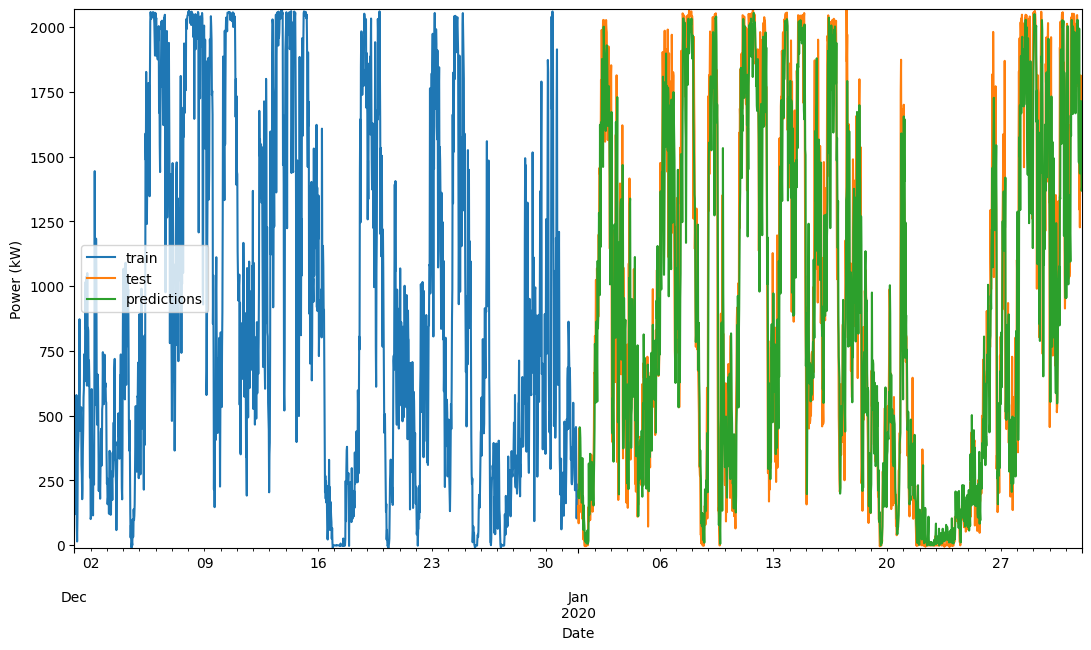

In [132]:
fig, ax = plt.subplots(figsize=(13, 7))
y_train[y_train.index >= "12-01-2019"].plot(ax=ax, label="train")
y_test[y_test.index < "02-01-2020"].plot(ax=ax, label="test")
predictions[predictions.index < "02-01-2020"].plot(ax=ax, label="predictions")
ax.set_ylabel("Power (kW)")
ax.set_ymargin(0)
ax.legend();

In [ ]:
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = y,
    initial_train_size = len(y_train),
    fixed_train_size   = True,
    steps              = 6,
    metric             = "mean_absolute_error",
    refit              = True,
    verbose            = False
)